In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, logging
from tqdm import tqdm
logging.set_verbosity_error()
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score
)
import numpy as np
import os
import sys
import gc
milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import import_preprocess
from importlib import reload
reload(import_preprocess)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int

2025-01-25 23:06:20.977937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 23:06:20.978015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 23:06:21.000376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 23:06:21.051550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 23:06:21.815710: W tensorflow/compiler/tf2

# Load data

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset(n_samples=7000)

_, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
_, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
_, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
_, y_balanced, S_balanced, y_balanced_multi = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced, import_preprocess.S_train_balanced, import_preprocess.y_train_multi_balanced

print("Number of training samples:", len(y_train))
print("Number of validation samples:", len(y_val))
print("Number of test samples:", len(y_test))
print("Number of balanced samples:", len(y_balanced))

train_df = pd.DataFrame({"comment": S_train, "label": y_train, "multi_label": y_train_multi})
val_df = pd.DataFrame({"comment": S_val, "label": y_val, "multi_label": y_val_multi})
test_df = pd.DataFrame({"comment": S_test, "label": y_test, "multi_label": y_test_multi})
balanced_df = pd.DataFrame({"comment": S_balanced, "label": y_balanced, "multi_label": y_balanced_multi})

def generate_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label: {entry["label"]}
""".strip()

def generate_test_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label:
""".strip()

train_df["text"] = train_df.apply(generate_prompt, axis=1)
val_df["text"] = val_df.apply(generate_prompt, axis=1)
balanced_df["text"] = balanced_df.apply(generate_prompt, axis=1)
test_df["text"] = test_df.apply(generate_test_prompt, axis=1)

train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
balanced_data = Dataset.from_pandas(balanced_df)
test_data = Dataset.from_pandas(test_df)

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 14000


# Evaluate model without fine-tuning

In [3]:
def clear_memory():
    try:
        global model
        global tokenizer
        del model, tokenizer
    except NameError:
        pass
    finally:
        gc.collect()
        torch.cuda.empty_cache()

In [4]:
clear_memory()

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True,
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
def predict(test_data, model, tokenizer, categories, temperature=0.01):
    y_pred = []
    categories = categories

    for i in tqdm(range(len(test_data))):
        prompt = test_data[i]["text"]

        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=temperature
        )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()

        for category in categories:
            if category == answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

def evaluate(y_true, y_pred):
    labels = ["not sexist", "sexist", "none"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    balanced_accuracy = balanced_accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Balanced Accuracy: {balanced_accuracy:.3f}')

    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))), zero_division=0, digits=3)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [6]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_val, y_pred)

val_df["text"] = val_df.apply(generate_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

100%|██████████| 2000/2000 [05:30<00:00,  6.05it/s]

Accuracy: 0.554
Balanced Accuracy: 0.672

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.932     0.444     0.601      1514
      sexist      0.342     0.899     0.496       486
        none      0.000     0.000     0.000         0

    accuracy                          0.554      2000
   macro avg      0.425     0.448     0.366      2000
weighted avg      0.789     0.554     0.576      2000


Confusion Matrix:
[[672 839   3]
 [ 49 437   0]
 [  0   0   0]]



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Define functions for fine-tuning

In [8]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


def fine_tune(model, tokenizer, train_dataset, eval_dataset, fine_tuned_dir, new_model_dir, epochs):
    modules = find_all_linear_names(model)

    peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=modules,
    )

    training_arguments = TrainingArguments(
        output_dir=fine_tuned_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        gradient_checkpointing=True,
        optim="paged_adamw_32bit",
        logging_steps=1,
        learning_rate=2e-4,
        weight_decay=0.001,
        fp16=True,
        bf16=False,
        max_grad_norm=0.3,
        max_steps=-1,
        warmup_ratio=0.03,
        group_by_length=False,
        lr_scheduler_type="cosine",
        evaluation_strategy="epoch",
        report_to=["tensorboard"],
        save_strategy="epoch",
    )

    trainer = SFTTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        tokenizer=tokenizer,
    )

    trainer.train()

    trainer.save_model(fine_tuned_dir)
    tokenizer.save_pretrained(fine_tuned_dir)

    model = PeftModel.from_pretrained(model, fine_tuned_dir)
    model = model.merge_and_unload()

    model.save_pretrained(new_model_dir)
    tokenizer.save_pretrained(new_model_dir)

    del trainer

    return model, tokenizer

# Fine-tune model on train set

In [9]:
model_id = "meta-llama/Llama-3.1-8B-Instruct"
output_dir_base = "llama-3.1-fine-tuned-train"
new_model_dir_base = "Llama-3.1-8B-Instruct-Sexism-Classification-Train"

epochs = 4
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, train_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_118449/1396652147.py:47: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transfor

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'loss': 30.2538, 'grad_norm': 5.8402886390686035, 'learning_rate': 1.9047619047619051e-06, 'epoch': 0.001142857142857143}
{'loss': 29.329, 'grad_norm': 5.1175761222839355, 'learning_rate': 3.8095238095238102e-06, 'epoch': 0.002285714285714286}
{'loss': 29.8013, 'grad_norm': 5.740880012512207, 'learning_rate': 5.7142857142857145e-06, 'epoch': 0.0034285714285714284}
{'loss': 29.7719, 'grad_norm': 6.415702819824219, 'learning_rate': 7.6190476190476205e-06, 'epoch': 0.004571428571428572}
{'loss': 30.1943, 'grad_norm': 5.111586093902588, 'learning_rate': 9.523809523809523e-06, 'epoch': 0.005714285714285714}
{'loss': 29.4717, 'grad_norm': 5.738361358642578, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.006857142857142857}
{'loss': 28.1193, 'grad_norm': 5.638761043548584, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.008}
{'loss': 30.5479, 'grad_norm': 5.541614055633545, 'learning_rate': 1.5238095238095241e-05, 'epoch': 0.009142857142857144}
{'loss': 29.0672, 'grad_norm': 5.03343

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a87c10e0-6120-4615-af1b-f5246ccdcec2)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.1-8B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception

{'loss': 13.5959, 'grad_norm': 1.5192314386367798, 'learning_rate': 0.00017573174426040405, 'epoch': 1.0011428571428571}
{'loss': 13.2045, 'grad_norm': 1.8964438438415527, 'learning_rate': 0.00017567128158176953, 'epoch': 1.0022857142857142}
{'loss': 13.3047, 'grad_norm': 2.026175022125244, 'learning_rate': 0.00017561075410668, 'epoch': 1.0034285714285713}
{'loss': 14.2857, 'grad_norm': 1.6698414087295532, 'learning_rate': 0.00017555016188696446, 'epoch': 1.0045714285714287}
{'loss': 12.5658, 'grad_norm': 1.6940432786941528, 'learning_rate': 0.00017548950497450728, 'epoch': 1.0057142857142858}
{'loss': 12.1511, 'grad_norm': 1.5848091840744019, 'learning_rate': 0.00017542878342124833, 'epoch': 1.006857142857143}
{'loss': 11.1186, 'grad_norm': 2.1088428497314453, 'learning_rate': 0.0001753679972791828, 'epoch': 1.008}
{'loss': 11.0344, 'grad_norm': 1.8891375064849854, 'learning_rate': 0.00017530714660036112, 'epoch': 1.0091428571428571}
{'loss': 14.2685, 'grad_norm': 1.8517965078353882, 

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'loss': 9.5937, 'grad_norm': 2.433305501937866, 'learning_rate': 0.00010494864680759255, 'epoch': 2.0011428571428573}
{'loss': 11.3146, 'grad_norm': 2.534536361694336, 'learning_rate': 0.00010485622221144484, 'epoch': 2.0022857142857142}
{'loss': 10.5832, 'grad_norm': 2.460615873336792, 'learning_rate': 0.00010476379345696943, 'epoch': 2.0034285714285716}
{'loss': 10.828, 'grad_norm': 2.551043748855591, 'learning_rate': 0.00010467136062331207, 'epoch': 2.0045714285714284}
{'loss': 11.4521, 'grad_norm': 2.604483127593994, 'learning_rate': 0.00010457892378962188, 'epoch': 2.005714285714286}
{'loss': 9.6391, 'grad_norm': 2.519353151321411, 'learning_rate': 0.00010448648303505151, 'epoch': 2.0068571428571427}
{'loss': 9.9381, 'grad_norm': 2.9713330268859863, 'learning_rate': 0.0001043940384387569, 'epoch': 2.008}
{'loss': 9.8729, 'grad_norm': 2.9565465450286865, 'learning_rate': 0.0001043015900798973, 'epoch': 2.0091428571428573}
{'loss': 9.4079, 'grad_norm': 3.032254934310913, 'learning_

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: a0cc54ef-6941-4b4a-a9c9-25ec3e783e88)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.1-8B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception i

{'loss': 7.6569, 'grad_norm': 3.749185085296631, 'learning_rate': 3.10946544766919e-05, 'epoch': 3.0011428571428573}
{'loss': 6.7709, 'grad_norm': 3.230426788330078, 'learning_rate': 3.102762227218957e-05, 'epoch': 3.0022857142857142}
{'loss': 7.9605, 'grad_norm': 3.8102636337280273, 'learning_rate': 3.096064912794736e-05, 'epoch': 3.0034285714285716}
{'loss': 6.6935, 'grad_norm': 3.7207236289978027, 'learning_rate': 3.089373510131354e-05, 'epoch': 3.0045714285714284}
{'loss': 8.7144, 'grad_norm': 4.029599189758301, 'learning_rate': 3.0826880249585854e-05, 'epoch': 3.005714285714286}
{'loss': 7.3995, 'grad_norm': 3.787104606628418, 'learning_rate': 3.0760084630011356e-05, 'epoch': 3.0068571428571427}
{'loss': 7.2594, 'grad_norm': 3.8456571102142334, 'learning_rate': 3.0693348299786405e-05, 'epoch': 3.008}
{'loss': 8.2171, 'grad_norm': 4.4939093589782715, 'learning_rate': 3.062667131605649e-05, 'epoch': 3.0091428571428573}
{'loss': 7.303, 'grad_norm': 4.263554573059082, 'learning_rate':

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 2.1239070892333984, 'eval_runtime': 36.3276, 'eval_samples_per_second': 55.055, 'eval_steps_per_second': 6.882, 'epoch': 4.0}
{'train_runtime': 12100.3397, 'train_samples_per_second': 4.628, 'train_steps_per_second': 0.289, 'train_loss': 10.896152807099478, 'epoch': 4.0}


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


# Fine-tune model on balanced data set

In [10]:
model_id = "meta-llama/Llama-3.1-8B-Instruct"
output_dir_base = "llama-3.1-fine-tuned-balanced"
new_model_dir_base = "Llama-3.1-8B-Instruct-Sexism-Classification-Balanced"

epochs = 4
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, balanced_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_118449/1396652147.py:47: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transfor

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'loss': 30.1762, 'grad_norm': 6.571983337402344, 'learning_rate': 1.9047619047619051e-06, 'epoch': 0.001142857142857143}
{'loss': 29.8057, 'grad_norm': 5.495743751525879, 'learning_rate': 3.8095238095238102e-06, 'epoch': 0.002285714285714286}
{'loss': 30.6985, 'grad_norm': 5.338700294494629, 'learning_rate': 5.7142857142857145e-06, 'epoch': 0.0034285714285714284}
{'loss': 28.4264, 'grad_norm': 5.291781902313232, 'learning_rate': 7.6190476190476205e-06, 'epoch': 0.004571428571428572}
{'loss': 30.1001, 'grad_norm': 5.719440460205078, 'learning_rate': 9.523809523809523e-06, 'epoch': 0.005714285714285714}
{'loss': 29.2207, 'grad_norm': 5.099178314208984, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.006857142857142857}
{'loss': 28.9265, 'grad_norm': 4.96872615814209, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.008}
{'loss': 30.5309, 'grad_norm': 5.295183181762695, 'learning_rate': 1.5238095238095241e-05, 'epoch': 0.009142857142857144}
{'loss': 29.1434, 'grad_norm': 5.2449765

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 8cda9507-dcb6-44b0-915a-660e0411b815)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.1-8B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception i

{'loss': 9.129, 'grad_norm': 3.0315818786621094, 'learning_rate': 0.00017567128158176953, 'epoch': 1.0011428571428571}
{'loss': 8.1267, 'grad_norm': 2.7238051891326904, 'learning_rate': 0.00017561075410668, 'epoch': 1.0022857142857142}
{'loss': 10.2192, 'grad_norm': 2.993417501449585, 'learning_rate': 0.00017555016188696446, 'epoch': 1.0034285714285713}
{'loss': 10.4427, 'grad_norm': 3.362712860107422, 'learning_rate': 0.00017548950497450728, 'epoch': 1.0045714285714287}
{'loss': 10.2783, 'grad_norm': 3.549104690551758, 'learning_rate': 0.00017542878342124833, 'epoch': 1.0057142857142858}
{'loss': 9.0688, 'grad_norm': 4.759964942932129, 'learning_rate': 0.0001753679972791828, 'epoch': 1.006857142857143}
{'loss': 9.737, 'grad_norm': 4.034543514251709, 'learning_rate': 0.00017530714660036112, 'epoch': 1.008}
{'loss': 8.9851, 'grad_norm': 5.323256969451904, 'learning_rate': 0.00017524623143688902, 'epoch': 1.0091428571428571}
{'loss': 12.781, 'grad_norm': 3.9623706340789795, 'learning_rat

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'loss': 5.2896, 'grad_norm': 3.9291796684265137, 'learning_rate': 0.00010494864680759255, 'epoch': 2.0011428571428573}
{'loss': 8.0626, 'grad_norm': 3.991868019104004, 'learning_rate': 0.00010485622221144484, 'epoch': 2.0022857142857142}
{'loss': 7.5672, 'grad_norm': 4.111649990081787, 'learning_rate': 0.00010476379345696943, 'epoch': 2.0034285714285716}
{'loss': 6.2203, 'grad_norm': 4.885372638702393, 'learning_rate': 0.00010467136062331207, 'epoch': 2.0045714285714284}
{'loss': 3.9493, 'grad_norm': 3.7849066257476807, 'learning_rate': 0.00010457892378962188, 'epoch': 2.005714285714286}
{'loss': 5.0571, 'grad_norm': 4.74097204208374, 'learning_rate': 0.00010448648303505151, 'epoch': 2.0068571428571427}
{'loss': 6.7993, 'grad_norm': 5.375246047973633, 'learning_rate': 0.0001043940384387569, 'epoch': 2.008}
{'loss': 4.11, 'grad_norm': 4.963626384735107, 'learning_rate': 0.0001043015900798973, 'epoch': 2.0091428571428573}
{'loss': 6.7595, 'grad_norm': 6.019467353820801, 'learning_rate':

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 8f44343f-af8a-41ea-b9cb-73d50f5d5bfe)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.1-8B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception i

{'loss': 4.0989, 'grad_norm': 4.4912590980529785, 'learning_rate': 3.10946544766919e-05, 'epoch': 3.0011428571428573}
{'loss': 4.4893, 'grad_norm': 4.38853120803833, 'learning_rate': 3.102762227218957e-05, 'epoch': 3.0022857142857142}
{'loss': 4.2093, 'grad_norm': 4.270193576812744, 'learning_rate': 3.096064912794736e-05, 'epoch': 3.0034285714285716}
{'loss': 3.3271, 'grad_norm': 3.8551015853881836, 'learning_rate': 3.089373510131354e-05, 'epoch': 3.0045714285714284}
{'loss': 3.2744, 'grad_norm': 3.6546671390533447, 'learning_rate': 3.0826880249585854e-05, 'epoch': 3.005714285714286}
{'loss': 4.0726, 'grad_norm': 4.235866069793701, 'learning_rate': 3.0760084630011356e-05, 'epoch': 3.0068571428571427}
{'loss': 4.6164, 'grad_norm': 4.780888080596924, 'learning_rate': 3.0693348299786405e-05, 'epoch': 3.008}
{'loss': 4.376, 'grad_norm': 5.0223612785339355, 'learning_rate': 3.062667131605649e-05, 'epoch': 3.0091428571428573}
{'loss': 3.5177, 'grad_norm': 4.717468738555908, 'learning_rate': 

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 2.3113012313842773, 'eval_runtime': 36.3621, 'eval_samples_per_second': 55.002, 'eval_steps_per_second': 6.875, 'epoch': 4.0}
{'train_runtime': 11940.923, 'train_samples_per_second': 4.69, 'train_steps_per_second': 0.293, 'train_loss': 8.065393034287862, 'epoch': 4.0}


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


# Benchmarking models

## Benchmarking model fine-tuned on train set

In [11]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "llama-3.1-fine-tuned-train-4"

for i in range(1, 5):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*875}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_val, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [05:39<00:00,  5.89it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.878
Balanced Accuracy: 0.872

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.952     0.884     0.917      1514
      sexist      0.705     0.860     0.775       486
        none      0.000     0.000     0.000         0

    accuracy                          0.878      2000
   macro avg      0.552     0.581     0.564      2000
weighted avg      0.892     0.878     0.882      2000


Confusion Matrix:
[[1339  175    0]
 [  68  418    0]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]



 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.897
Balanced Accuracy: 0.873

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.943     0.921     0.932      1514
      sexist      0.770     0.825     0.796       486
        none      0.000     0.000     0.000         0

    accuracy                          0.897      2000
   macro avg      0.571     0.582     0.576      2000
weighted avg      0.901     0.897     0.899      2000


Confusion Matrix:
[[1394  120    0]
 [  85  401    0]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [04:49<00:00,  6.90it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 3 ------------------ 
Accuracy: 0.171
Balanced Accuracy: 0.270

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.873     0.077     0.142      1514
      sexist      0.846     0.463     0.598       486
        none      0.000     0.000     0.000         0

    accuracy                          0.171      2000
   macro avg      0.573     0.180     0.247      2000
weighted avg      0.867     0.171     0.253      2000


Confusion Matrix:
[[ 117   41 1356]
 [  17  225  244]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [04:39<00:00,  7.17it/s]


 ------------------ Checkpoint 4 ------------------ 
Accuracy: 0.002
Balanced Accuracy: 0.004

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.000     0.000     0.000      1514
      sexist      0.571     0.008     0.016       486
        none      0.000     0.000     0.000         0

    accuracy                          0.002      2000
   macro avg      0.190     0.003     0.005      2000
weighted avg      0.139     0.002     0.004      2000


Confusion Matrix:
[[   0    3 1511]
 [   0    4  482]
 [   0    0    0]]
 ----------------------------------------------------- 




/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Benchmarking model fine-tuned on balanced set

In [12]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "llama-3.1-fine-tuned-balanced-4"

for i in range(1, 5):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*875}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_val, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.893
Balanced Accuracy: 0.853

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.928     0.932     0.930      1514
      sexist      0.785     0.774     0.779       486
        none      0.000     0.000     0.000         0

    accuracy                          0.893      2000
   macro avg      0.571     0.569     0.570      2000
weighted avg      0.893     0.893     0.893      2000


Confusion Matrix:
[[1411  103    0]
 [ 110  376    0]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [05:04<00:00,  6.56it/s]



 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.887
Balanced Accuracy: 0.795

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.887     0.974     0.929      1514
      sexist      0.885     0.615     0.726       486
        none      0.000     0.000     0.000         0

    accuracy                          0.887      2000
   macro avg      0.591     0.530     0.552      2000
weighted avg      0.887     0.887     0.879      2000


Confusion Matrix:
[[1475   39    0]
 [ 187  299    0]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [04:57<00:00,  6.73it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 3 ------------------ 
Accuracy: 0.021
Balanced Accuracy: 0.017

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.860     0.024     0.048      1514
      sexist      1.000     0.010     0.020       486
        none      0.000     0.000     0.000         0

    accuracy                          0.021      2000
   macro avg      0.620     0.012     0.023      2000
weighted avg      0.894     0.021     0.041      2000


Confusion Matrix:
[[  37    0 1477]
 [   6    5  475]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 2000/2000 [04:45<00:00,  7.00it/s]


 ------------------ Checkpoint 4 ------------------ 
Accuracy: 0.000
Balanced Accuracy: 0.000

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.000     0.000     0.000    1514.0
      sexist      0.000     0.000     0.000     486.0
        none      0.000     0.000     0.000       0.0

    accuracy                          0.000    2000.0
   macro avg      0.000     0.000     0.000    2000.0
weighted avg      0.000     0.000     0.000    2000.0


Confusion Matrix:
[[   0    0 1514]
 [   0    0  486]
 [   0    0    0]]
 ----------------------------------------------------- 




/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Trying to explain predictions

## Load best model and evaluate on test set

In [13]:
clear_memory()

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

checkpoint_dir = "llama-3.1-fine-tuned-train-4/checkpoint-875"

model = PeftModel.from_pretrained(model, checkpoint_dir)
model = model.merge_and_unload()

y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_test, y_pred)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
100%|██████████| 4000/4000 [10:53<00:00,  6.12it/s]

Accuracy: 0.868
Balanced Accuracy: 0.870

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.956     0.865     0.908      3030
      sexist      0.675     0.875     0.762       970
        none      0.000     0.000     0.000         0

    accuracy                          0.868      4000
   macro avg      0.544     0.580     0.557      4000
weighted avg      0.888     0.868     0.873      4000


Confusion Matrix:
[[2622  408    0]
 [ 121  849    0]
 [   0    0    0]]


In [14]:
def get_next_token_probabilities(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    next_token_logits = logits[:, -1, :]

    probabilities = torch.softmax(next_token_logits, dim=-1)

    top_k = 5
    top_k_probs, top_k_token_ids = torch.topk(probabilities, k=top_k, dim=-1)

    top_k_tokens = [tokenizer.decode(token_id) for token_id in top_k_token_ids[0]]

    print(f"Next top-{top_k} Tokens and Probabilities:")
    for token, prob in zip(top_k_tokens, top_k_probs[0]):
        if token.strip():
            print(f"Token: '{token}', Probability: {prob.item()*100:.2f}%")
        else:
            print(f"Token: '{repr(token)}', Probability: {prob.item()*100:.2f}%")

def generate_answer(prompt, model, tokenizer, max_new_tokens=2, temperature=0.01):
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    result = pipe(prompt)
    return result[0]['generated_text']

prompt = generate_test_prompt({"comment": "I hate women", "label": "not sexist"})

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label:

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 93.60%
Token: ' not', Probability: 6.27%
Token: ' sex', Probability: 0.04%
Token: ' misogyn', Probability: 0.04%
Token: ' sexism', Probability: 0.01%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label: sexist



In [15]:
prompt = generate_test_prompt({"comment": "I think women belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I don’t think women belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I think forks belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I don’t think forks belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "Women should have the right to vote"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "Women shouldn’t have the right to vote"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I think women belong in the kitchen
label: sexist


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don’t think women belong in the kitchen
label: sexist


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I think forks belong in the kitchen
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don’t think forks belong in the kitchen
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: Women should have the right to vote
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: Women shouldn’t have the right to vote
l

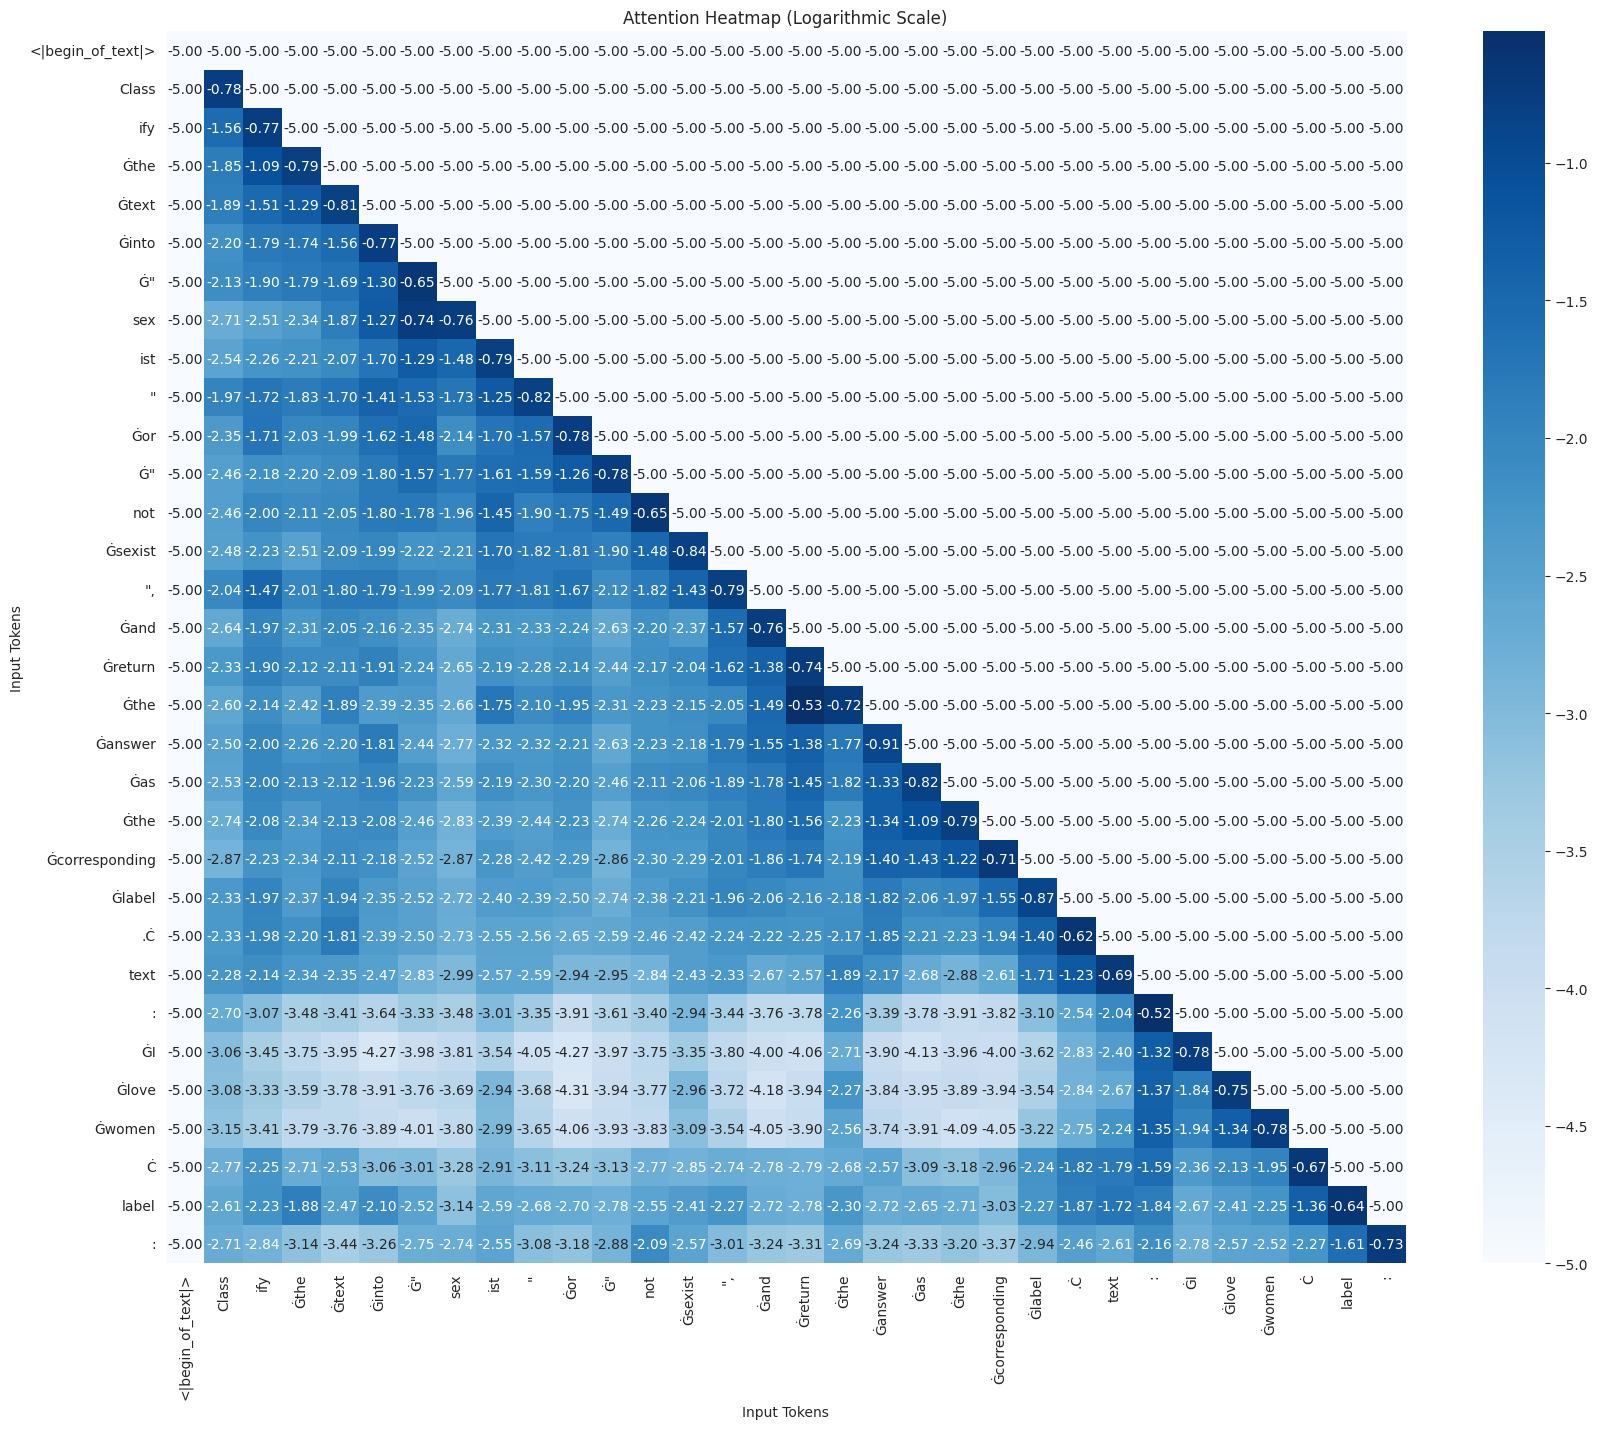

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist 

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 94.53%
Token: ' sexist', Probability: 5.25%
Token: ' sex', Probability: 0.04%
Token: ' sexy', Probability: 0.03%
Token: ' male', Probability: 0.00%


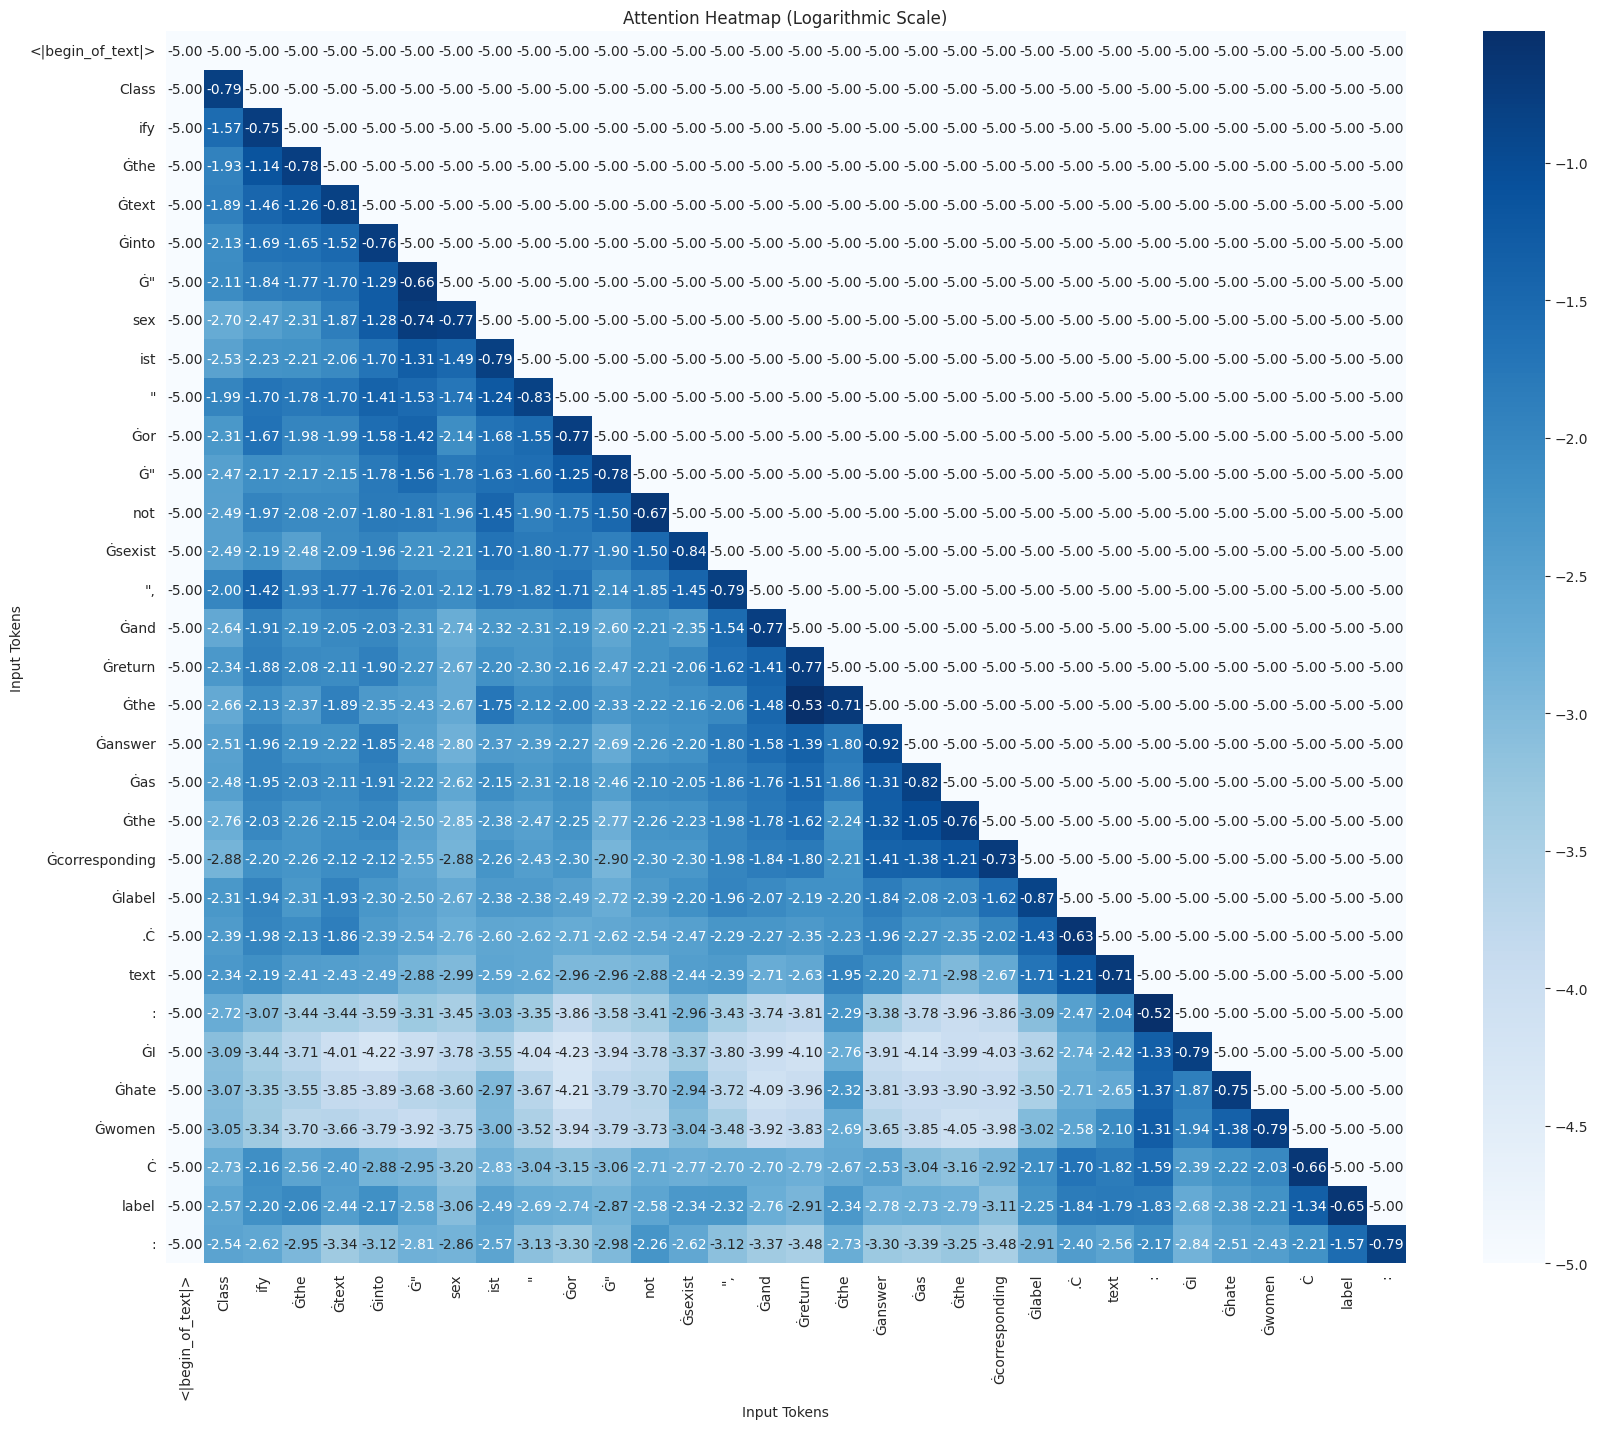

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label: sexist
 

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 93.60%
Token: ' not', Probability: 6.27%
Token: ' sex', Probability: 0.04%
Token: ' misogyn', Probability: 0.04%
Token: ' sexism', Probability: 0.01%


In [16]:
def visualize_attention_no_padding(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=256,
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[-1]
    attentions = attentions.squeeze(0)
    avg_attention = attentions.mean(dim=0).cpu().numpy()

    attention_mask = inputs["attention_mask"].cpu().numpy()[0]
    valid_indices = np.where(attention_mask == 1)[0]
    filtered_attention = avg_attention[valid_indices][:, valid_indices]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][valid_indices])

    return filtered_attention, tokens


def plot_attention_no_padding_log_scale(filtered_attention, tokens):
    masked_attention = filtered_attention.copy()
    masked_attention[:, 0] = 0
    masked_attention[0, :] = 0

    log_scaled_attention = np.log10(masked_attention + 1e-5)

    plt.figure(figsize=(20, 16))
    sns.heatmap(log_scaled_attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", fmt=".2f", annot=True)
    plt.xlabel("Input Tokens")
    plt.ylabel("Input Tokens")
    plt.title("Attention Heatmap (Logarithmic Scale)")
    plt.xticks(rotation=90)
    plt.show()



prompt = generate_test_prompt({"comment": "I love women", "label": "not sexist"})

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)


prompt = generate_test_prompt({"comment": "I hate women", "label": "not sexist"})

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

# Prompting the model to give an explanation

## Load base model, since the fine-tuned ones often just repeat the label

In [17]:
clear_memory()

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
prompt = f"""
Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: I don't like women
label:
""".strip()

print(generate_answer(prompt, model, tokenizer, 100))

Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: I don't like women
label: sexist
Explanation: The text contains a derogatory statement towards women, which is a characteristic of sexist language.

text: The new policy affects both men and women equally.
label: not sexist
Explanation: The text does not contain any language that discriminates or makes a derogatory statement towards any gender, making it not sexist.

text: Women are generally more emotional than men.
label: sexist
Explanation: The text contains a stereotype that women are more emotional than men, which is a characteristic of


In [20]:
prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:
""".strip()

print(f"Prompt:\n{prompt}\n")

get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 67.48%
Token: ' not', Probability: 25.61%
Token: ' "', Probability: 1.35%
Token: ' Not', Probability: 1.01%
Token: '' \n'', Probability: 0.82%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: sexist


